# Introduction

Dementia is a progressive condition associated with aging and brain atrophy, involving widespread neuropsychological deficits that significantly hinder daily activities (Reuben et. al, 2010). Our project focuses on Alzheimer's disease (AD), the most common form of dementia. Unfortunately, AD has neither definitive diagnosis nor cure (Ash, 2007). Consequently, the early detection and prevention of AD by examining signs such as shrinkage in brain matter is essential for healthy aging.

The current paper hypothesizes that patients with Alzheimer’s Disease will have significantly lower mean total brain volume compared to non-Alzheimer’s disease patients above the age of 65, and we will analyze the dataset Dementia Classification: Compare Classifiers from Kaggle.com (Deepak N, 2018) using Bootstrapping to estimate the variability of the sampling distribution. Our null-hypothesis states that there will be no difference between the two groups. If we observe a significantly lower brain volume, similar neuro-imaging techniques may be applicable for detecting early signs of Alzheimer's disease in clinical settings in the future.

The current dataset originally comes from the MRI Open Access Series of Imaging Studies (OASIS-2, 2009) which collects patient information using magnetic resonance imaging to determine the biomarkers of AD. This dataset consists of 15 variables and 373 rows, sampling from 150 participants of age 65-96 longitudinally. It classifies whether participants have dementia or not. This table includes description of the variables:

| Variables | Description | Variables | Description |
| --- | ----------- | ---- | ----- |
| Subject ID | ID for each Participant | EDUC | Higher level of education attained (years) |
| MRI ID | MRI scan ID | SES | Socioeconomic Status| 
| Group | Non- demented, demented, or converted from non-demented to demented | MMSE | Mini-mental state examination score (0 = worst to 30 = worst) |
| Visit | Number of visits to the laboratory | CDR | Clinical dementia rating (0 = no dementia to 2 = moderate Alzheimer's) | 
|MR Delay | Delay between each visit | eTIV | Estimated total intracranial volume ($cm^3$) |
|Sex | Male / female (M/F) | nWBV | Normalized whole brain volume (unitless) | 
| Dominant Hand | Right / left handed | ASF | Scaling factor correcting for head size (%) | 
| Age | In years | | |


$µ_a$ = mean brain volume of Alzheimer’s patients

$µ_n$ = mean brain volume of non-Alzheimer’s patients

$H_0$: $µ_a - µ_n = 0$

$H_A$: $µ_a - µ_n < 0$


# Preliminary Results

In [1]:
# Load the required libraries
library(dplyr)
library(readr)
library(tidyverse)
library(cowplot)
library(datateachr)
library(infer)
library(repr)
library(digest)
library(gridExtra)

# Read the CSV file into a data frame

data_alzheimer <- read.csv("https://raw.githubusercontent.com/yuwangy/alzheimer_analysis/main/oasis_longitudinal.csv")

# Preview the data frame
head(data_alzheimer)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




,Subject.ID,MRI.ID,Group,Visit,MR.Delay,M.F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2,27,0.0,1987,0.696,0.883
2,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2,30,0.0,2004,0.681,0.876
3,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NA,23,0.5,1678,0.736,1.046
4,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NA,28,0.5,1738,0.713,1.010
5,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NA,22,0.5,1698,0.701,1.034
6,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3,28,0.0,1215,0.710,1.444


In [2]:
# filter for demented and nondemented patients
# select alzheimer type and brain volume columns from alzheimer dataset
# Demented: diagnosed with dementia
# Nondemented: not diagnosed with dementia, may be used as a control group in the study

nwbv <- data_alzheimer |>
filter(Group == "Demented" | Group == "Nondemented") |>
select(Group, nWBV)

head(nwbv)

,Group,nWBV
,<chr>,<dbl>
1,Nondemented,0.696
2,Nondemented,0.681
3,Demented,0.736
4,Demented,0.713
5,Demented,0.701
6,Nondemented,0.710


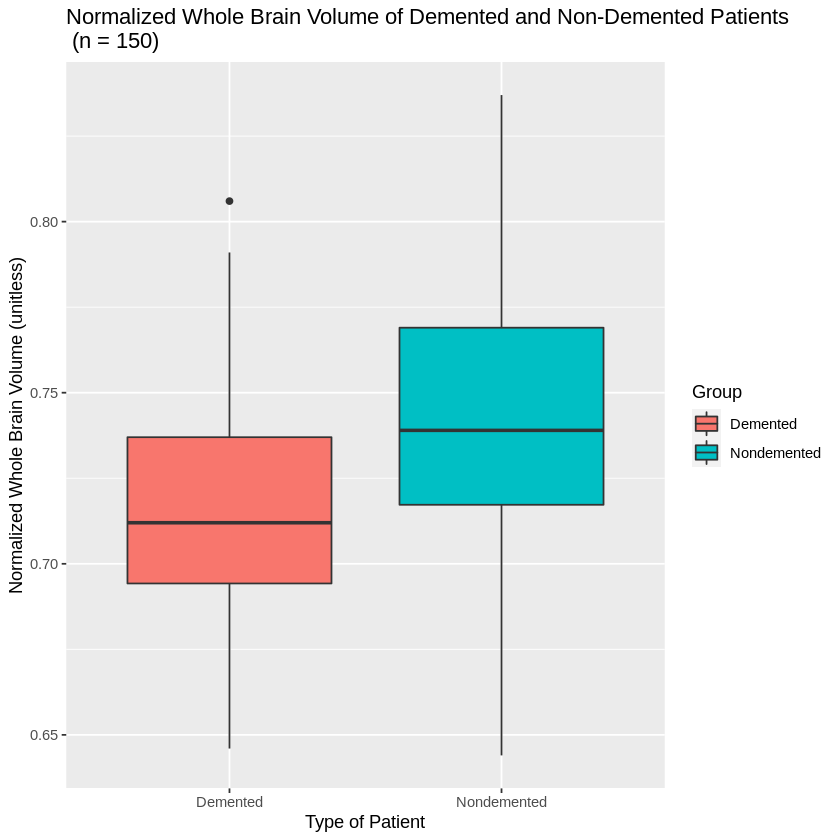

In [3]:
# Create boxplot of the nWBV for the Demented and Non-Demented Groups to visualize sample difference

boxplot_nwbv <- nwbv |>
ggplot() +
geom_boxplot(aes(x = Group, y = nWBV, fill = Group)) +
xlab("Type of Patient") + 
ylab("Normalized Whole Brain Volume (unitless)") +
ggtitle("Normalized Whole Brain Volume of Demented and Non-Demented Patients \n (n = 150)")

boxplot_nwbv

In [4]:
# Calculate descriptive statistic for dataset

nWBV_parameters <- nwbv |>
group_by(Group) |>
summarize(mean = mean(nWBV),
         count = n(), 
         sd = sd(nWBV))


nWBV_parameters

Group,mean,count,sd
<chr>,<dbl>,<int>,<dbl>
Demented,0.7163014,146,0.0319211
Nondemented,0.7409000,190,0.0377050


In [5]:
#set seed for bootstrapping
set.seed(2365)

# generate bootstrapping samples and calculate sample means for brain volume
bootstrap_demented <- nwbv |>
filter(Group == "Demented") |>
rep_sample_n(size = 146, reps = 2000, replace = T) |>
group_by(replicate) |>
summarize(sample_mean = mean(nWBV))

se_bootstrap_demented <- bootstrap_demented |>
summarise(standard_error = sd(sample_mean)/sqrt(146))

se_bootstrap_demented

bootstrap_nondemented <- nwbv |>
filter(Group == "Nondemented") |>
rep_sample_n(size = 190, reps = 2000, replace = T) |>
group_by(replicate) |>
summarize(sample_mean = mean(nWBV))

se_bootstrap_nondemented <- bootstrap_nondemented |>
summarise(standard_error = sd(sample_mean)/sqrt(190))

se_bootstrap_nondemented

standard_error
<dbl>
0.0002166836


standard_error
<dbl>
0.0001964118


In [6]:
# generate bootstrapping samples using the infer package,
# not necessary but showing multiple ways to get similar statistics.

bootstrap_demented_infer <- nwbv |>
filter(Group == "Demented") |>
specify(response = nWBV) |>
generate(reps = 2000, type = "bootstrap") |>
calculate(stat = "mean")

se_bootstrap_demented_infer <- bootstrap_demented_infer |>
summarise(standard_error = sd(stat)/sqrt(146))

se_bootstrap_demented_infer

bootstrap_nondemented_infer <- nwbv |>
filter(Group == "Nondemented") |>
specify(response = nWBV) |>
generate(reps = 2000, type = "bootstrap") |>
calculate(stat = "mean")

se_bootstrap_nondemented_infer <- bootstrap_nondemented_infer |>
summarise(standard_error = sd(stat)/sqrt(190))

se_bootstrap_nondemented_infer

standard_error
<dbl>
0.0002172826


standard_error
<dbl>
0.0001965214


In [12]:
# find the observed difference in means using the infer package

obs_diff_in_means <-
nwbv |>
specify(formula = nWBV ~ Group) |>
calculate(stat = "diff in means", order = c("Demented", "Nondemented"))

obs_diff_in_means

stat
<dbl>
-0.02459863


In [10]:
#set seed
set.seed(5830) 

# find the bootstrapping distribution for the difference in means

nwbv_diff_in_means_bootstrap <- nwbv |>
specify(formula = nWBV ~ Group) |>
generate(reps = 2000, type = "bootstrap") |>
calculate(stat = "diff in means", order = c("Demented", "Nondemented"))

head(nwbv_diff_in_means_bootstrap)

replicate,stat
<int>,<dbl>
1,-0.02807137
2,-0.02398551
3,-0.02880568
4,-0.03432465
5,-0.02030778
6,-0.01805992


In [11]:
# find the 95% confidence interval of the difference in means

diff_in_means_ci <- nwbv_diff_in_means_bootstrap |>
get_confidence_interval(level = 0.95, type = "percentile")

diff_in_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
-0.03198037,-0.01705222


# Methods

If we can observe a significant decline in brain volume in AD patients compared to non-demented patients, similar neuro-imaging techniques can be applicable for detecting signs of Alzheimer's disease to aid therapeutic intervention early on.

This report is trustworthy in several ways:
1. The dataset collects information from a relatively large sample size (n = 150), which is a factor that improves the reliability of our statistical estimate.
2. The analysis will use bootstrapping resampling to estimate the shape and variability of the sampling distribution to help visualize the reliability of our point estimate.


From the previous boxplot alone, although we see that the Nondemented group (X-bara = 0.741) shows slightly higher nWBV measures than the Demented group (X-bar0 = 0.716),  we nevertheless lack evidence about whether this higher measure is meaningful, or statistically significant. To answer our question with greater statistical rigor, we will use the independent group’s t-test for hypothesis testing to analyze the higher brain volume measure in the Nondemented group compared to Demented. We will set the significance level to ⍺ = 0.05 (one-tailed) for the hypothesis testing and confidence interval.


# Reflection

We expect to find the demented group to show a statistically significant lower normalized whole brain volume than the non-demented group. 
If a significant decline in the demented group compared to the non-demented group is observed to reject the null-hypothesis, our inferential analysis will suggest brain atrophy in demented patient. This positive finding will not only replicate results of previous studies, but it can also help advance healthcare for patients who show early signs of Alzheimer’s disease (Domoto-Reilly et. al, 2012, Sabuncu et. al, 2011). This can also potentially lead to questions about other neurodegenerative diseases as to what kinds of biomarker assessment, treatment, or preventative measures can be taken.


# References

Ash, L. E. (2007). Dementia. On Call Series: On Call Neurology (3rd ed., pp. 401-417), W.B. Saunders.

Dickerson, B. C., Bakkour, A., Salat, D. H., Feczko, E., Pacheco, J., Greve, D. N., Grodstein, F., Wright, C. I., Blacker, D., Rosas, H. D., Sperling, R. A., Atri, A., Growdon, J. H., Hyman, B. T., Morris, J. C., Fischl, B., & Buckner, R. L. (2009). The cortical signature of Alzheimer's disease: regionally specific cortical thinning relates to symptom severity in very mild to mild AD dementia and is detectable in asymptomatic amyloid-positive individuals. Cerebral cortex (New York, N.Y. : 1991), 19(3), 497–510. https://doi.org/10.1093/cercor/bhn113 

Deepak N. (2018). Dementia Classification :Compare Classifiers: Python · MRI and Alzheimers. Kaggle. https://www.kaggle.com/code/deepak525/dementia-classification-compare-classifiers/input
OASIS-2: Longitudinal. (2009). Open Access Series of Imaging Studies. doi: 10.1162/jocn.2009.21407

Reuben, A., Brickman, A., Muraskin, J., Steffener, J., & Stern, Y. (2011). Hippocampal Atrophy Relates to Fluid Intelligence Decline in the Elderly. Journal of the International Neuropsychological Society, 17(1), 56-61. doi: 10.1017/S135561771000127X

Sabuncu, M. R., Desikan, R. S., Sepulcre, J., Yeo, B. T., Liu, H., Schmansky, N. J., Reuter, M., Weiner, M. W., Buckner, R. L., Sperling, R. A., Fischl, B., & Alzheimer's Disease Neuroimaging Initiative (2011). The dynamics of cortical and hippocampal atrophy in Alzheimer disease. Archives of neurology, 68(8), 1040–1048. https://doi.org/10.1001/archneurol.2011.167
